# Mode decomposition of an undulator beam
awojdyla@lbl.gov, ChuzidaChen@lbl.gov, April 2025

based on `undulator beam near resonance.ipynb` (Dec 2021)

In [11]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
filename = '/Users/awojdyla/Downloads/tender/tender_10m_k=2.0_E=2000ev.mat'

# Load the MATLAB file
data = loadmat(filename)


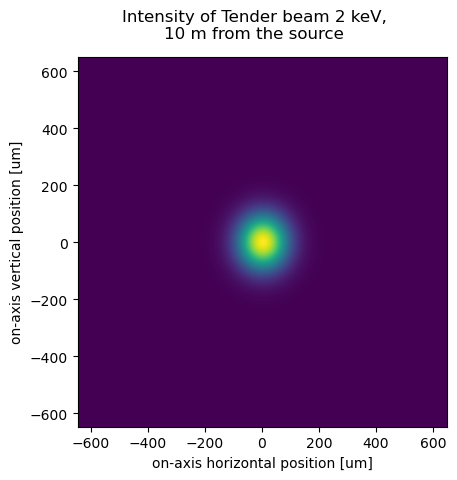

In [12]:
#unpack data
x_m = np.squeeze(data['x_mm'])*1e-3
y_m = np.squeeze(data['y_mm'])*1e-3
E_eV = data['E_eV']
amplitude = data['amplitude']
phase_rad = data['phase_rad']

# field is sampled at 10m, cast as a complex np array
E_10m = amplitude*np.exp(1j*phase_rad)

# display
extent=(x_m[1]*1e6,x_m[-1]*1e6,y_m[1]*1e6,y_m[-1]*1e6)
plt.imshow(np.abs(E_10m)**2, extent = extent)
plt.xlabel('on-axis horizontal position [um]')
plt.ylabel('on-axis vertical position [um]')

plt.suptitle('Intensity of Tender beam 2 keV,\n10 m from the source')
plt.show()


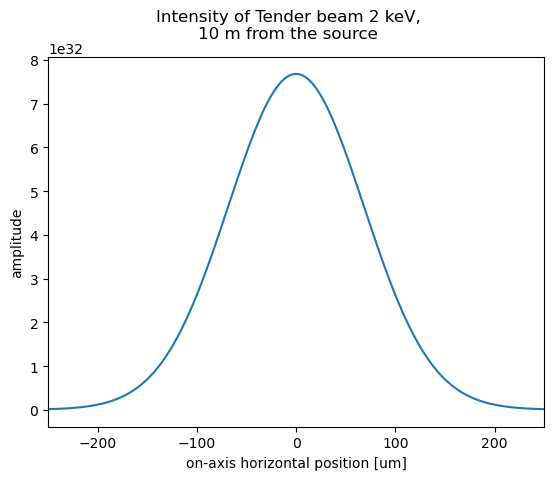

In [13]:
plt.plot(x_m*1e6, np.abs(E_10m[:,256])**2)
plt.xlabel('on-axis horizontal position [um]')
plt.ylabel('amplitude')

plt.suptitle('Intensity of Tender beam 2 keV,\n10 m from the source')
plt.xlim((-250,250))
plt.show()

In [16]:
def beam_stats_1D(x_m, I):
    Itot = np.sum(I)
    mu_m = np.sum(x_m * I)/np.sum(I)
    sigma_rms_m= np.sqrt(np.sum((x_m - mu_m)**2 * I)/np.sum(I))
    return Itot, mu_m, sigma_rms_m   

def beam_stats_2D(x_m, y_m, I):
    Itot = np.sum(I)
    I_x = np.sum(I, axis=0)
    mu_x_m = np.sum(x_m * I_x)/np.sum(I_x)
    sigma_x_rms_m= np.sqrt(np.sum((x_m - mu_x_m)**2 * I_x)/np.sum(I_x))
    I_y = np.sum(I, axis=1)
    mu_y_m = np.sum(y_m * I_y)/np.sum(I_y)
    sigma_y_rms_m= np.sqrt(np.sum((y_m - mu_y_m)**2 * I_y)/np.sum(I_y))
    
    return Itot, mu_x_m, mu_y_m, sigma_x_rms_m, sigma_y_rms_m

(Itot, mu_x_m, mu_y_m, sigma_x_rms_m, sigma_y_rms_m) = beam_stats_2D(x_m, y_m, np.abs(E_10m)**2)


In [8]:
Itot, mu_x_m, mu_y_m, sigma_x_rms_m, sigma_y_rms_m

(3.182865989173741e+36,
 1.9356389666879723e-13,
 -1.224465323749603e-07,
 6.350974216560524e-05,
 6.984690774292549e-05)

In [14]:
# define a zero-centered fourier transform
def ft(t):
    return np.fft.fftshift( np.fft.fft2(np.fft.ifftshift(t)))

def ift(t):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(t)))

# define the frequency axis
def fs(t):
    N = len(t)
    df_cpm = 1/(t[-1]-t[0])
    f_cpm = np.fft.fftshift(np.array([df_cpm*n if n<N/2 else df_cpm*(n-N) for n in range(N)]))
    return f_cpm

# define a propogation using the Fresnel propagator in the Fourier space
def propTF(E_in,L_m,lambda_m,z_m):
    #get input field array size
    (Nx, Ny)=np.shape(E_in); 
    dx=L_m/Nx; #sample interval

    #(dx<lambda.*z/L)

    fx = fs(np.arange(Nx)*dx);
    if Ny>2:
        fy = fs(np.arange(Ny)*dx);
    else:
        fy = 0;

    [FX,FY]= np.meshgrid(fx,fy);

    H=np.exp(-1j*np.pi*lambda_m*z_m*(FX**2+FY**2))

    E_out = ft(ft(E_in)*H);
    
    return E_out

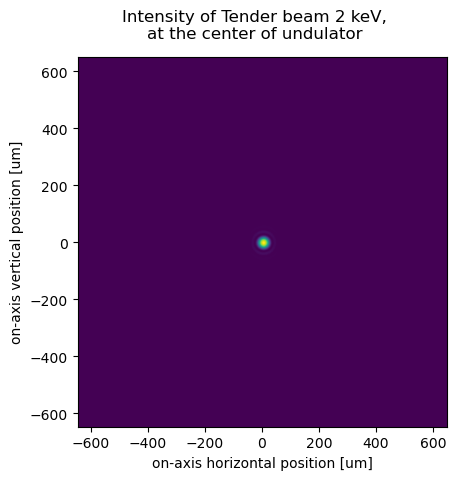

In [15]:
# screen size (for propagation)
Dx_m = x_m[-1]-x_m[1]
# equivalent wavelength (used by the propagator)
lambda_m = 1239e-9/E_eV
# distance away from the center of the undulator
z0_m = -10

# backpropagate the beam to the center of the undulator
E_0m = propTF(E_10m,Dx_m,lambda_m, z0_m)

# display
extent=(x_m[1]*1e6,x_m[-1]*1e6,y_m[1]*1e6,y_m[-1]*1e6)
plt.imshow(np.abs(E_0m)**2,  extent = extent)
plt.suptitle('Intensity of Tender beam 2 keV,\nat the center of undulator')
plt.xlabel('on-axis horizontal position [um]')
plt.ylabel('on-axis vertical position [um]')
plt.show()

In [18]:
(Itot, mu_x_m, mu_y_m, sigma_x_rms_m, sigma_y_rms_m) = beam_stats_2D(x_m, y_m, np.abs(E_0m)**2)
sigma_x_rms_m, sigma_y_rms_m

(2.3545824972439427e-05, 2.5482647089478135e-05)

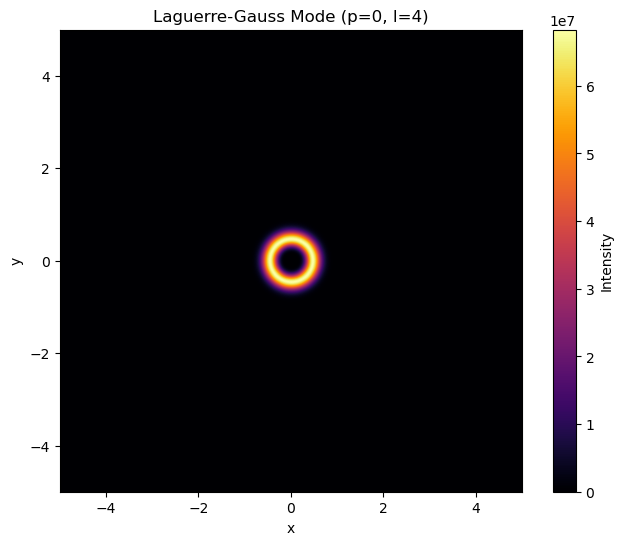

In [212]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

def laguerre_gauss_mode(p, l, r, phi, w0):
    """
    Calculate the Laguerre-Gauss mode.
    
    Parameters:
    p (int): Radial index
    l (int): Azimuthal index
    r (ndarray): Radial coordinates
    phi (ndarray): Azimuthal coordinates
    w0 (float): Beam waist
    
    Returns:
    ndarray: Laguerre-Gauss mode
    """
    r2 = r**2
    w = w0
    normalization = np.sqrt(2 * np.math.factorial(p) / (np.pi * np.math.factorial(p + np.abs(l))))
    laguerre_poly = sp.genlaguerre(p, np.abs(l))(2 * r2 / w**2)
    gaussian_envelope = np.exp(-r2 / w**2)
    phase_factor = np.exp(1j * l * phi)
    
    return normalization * (r * np.sqrt(2) / w)**np.abs(l) * laguerre_poly * gaussian_envelope * phase_factor

def LG_mode_gen(p, l, r, phi, w0, z=0):
    """Generate Laguerre-Gaussian mode with indices p, l at coordinates r, phi"""
    # Beam parameters
    zR = np.pi * w0**2  # Rayleigh range
    w = w0 * np.sqrt(1 + (z/zR)**2)  # Beam width at z
    R = z * (1 + (zR/z)**2) if z != 0 else np.inf  # Radius of curvature
    gouy = np.arctan(z/zR)  # Gouy phase
    
    # Normalization constant
    C = np.sqrt(2 * factorial(p) / (np.pi * factorial(p + abs(l))))
    
    # Associated Laguerre polynomial
    laguerre = genlaguerre(p, abs(l))
    
    # Calculate mode
    norm = C / w
    radial = (np.sqrt(2) * r / w) ** abs(l)
    lag_part = laguerre(2 * r**2 / w**2)
    gaussian = np.exp(-r**2 / w**2)
    phase = np.exp(1j * l * phi)
    
    # Additional phase terms
    k = 2 * np.pi  # Assuming wavelength = 1 for simplicity
    propagation_phase = np.exp(1j * (k*z - (2*p + abs(l) + 1) * gouy))
    curvature_phase = np.exp(1j * k * r**2 / (2*R)) if z != 0 else 1
    
    return norm * radial * lag_part * gaussian * phase * propagation_phase * curvature_phase


# Parameters
p = 0  # Radial index
l = 4  # Azimuthal index
w0 = sigma_x_rms_m  # Beam waist
#grid_size = 500
#x = np.linspace(-5, 5, grid_size)
#y = np.linspace(-5, 5, grid_size)
X, Y = np.meshgrid(x_m, y_m)
r = np.sqrt(X**2 + Y**2)
phi = np.arctan2(Y, X)

# Calculate Laguerre-Gauss mode
LG_mode = LG_mode_gen(p, l, r, phi, w0)

# Plot the intensity of the Laguerre-Gauss mode
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(LG_mode)**2, extent=[-5, 5, -5, 5], cmap='inferno')
plt.colorbar(label='Intensity')
plt.title(f'Laguerre-Gauss Mode (p={p}, l={l})')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [129]:
N=10

LG_modes = ()
for i in np.arange(N):
    #LG_modes += (laguerre_gauss_mode(0, i, r, phi, w0),)
    LG_mode = LG_mode_gen(0, i, r, phi, w0)
    LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
    LG_modes += (LG_mode,)

In [130]:
#LG_mode = LG_mode_gen(0, 9, r, phi, w0)
#LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
np.sum(np.abs(LG_mode*np.conjugate(LG_mode)))

0.9999999999999997

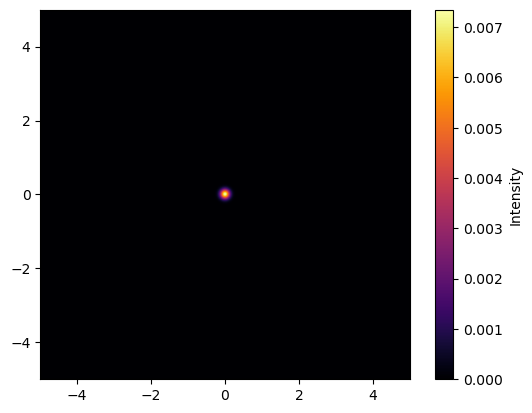

In [152]:
plt.imshow(np.abs(LG_modes[0])**2, extent=[-5, 5, -5, 5], cmap='inferno')
plt.colorbar(label='Intensity')
plt.show()

8.029019379949021e-18


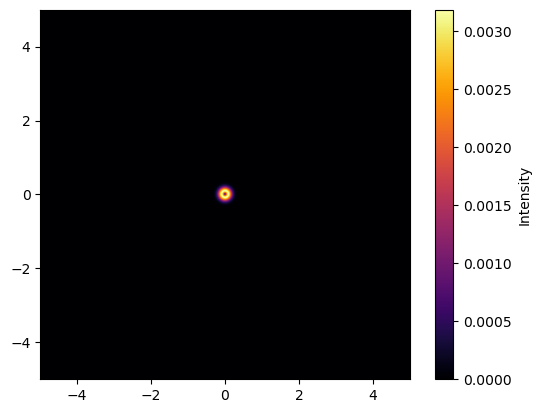

In [ ]:
# works
overlap = np.abs(np.sum(LG_modes[0]*np.conjugate(LG_modes[2])))
print(np.abs(np.sum(LG_modes[0]*np.conjugate(LG_modes[2]))))
plt.imshow(np.abs(LG_modes[0]*np.conjugate(LG_modes[1])), extent=[-5, 5, -5, 5], cmap='inferno')
plt.colorbar(label='Intensity')
plt.show()

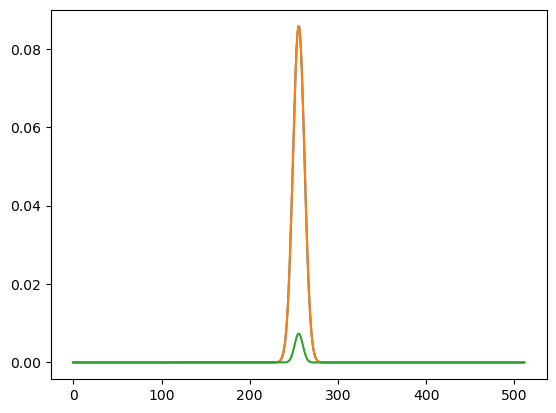

0.08570647640734513


In [169]:
a = np.abs(LG_modes[0])
b = np.abs(np.conjugate(LG_modes[0]))
plt.plot(a[:,256])
plt.plot(b[:,256])
plt.plot(a[:,256]*b[:,256])
plt.show()
ab_sum = np.abs(np.sum(a[:,256]*b[:,256]))
print(ab_sum)

In [ ]:
N=10

LG_modes = ()

for i in np.arange(N):
    #LG_modes += (laguerre_gauss_mode(0, i, r, phi, w0),)
    LG_mode = LG_mode_gen(i, 0, r, phi, w0)
    LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
    LG_modes += (LG_mode,)

In [253]:
LG_modes = ()
indices = ()
M = 5
N = 5
for i in np.arange(M):
    for j in np.arange(N):
        indices += ((i,j),)
        LG_mode = LG_mode_gen(i, j, r, phi, w0)
        LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
        LG_modes += (LG_mode,)

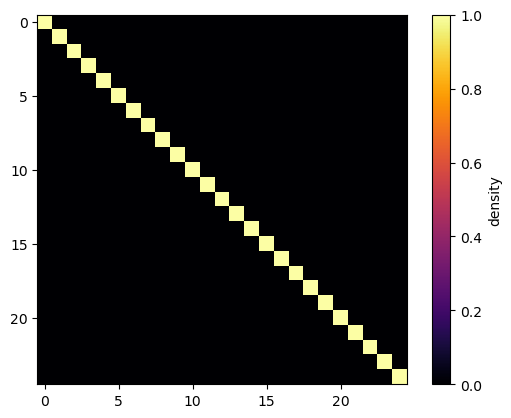

In [254]:
overlaps = np.zeros((M*N, M*N))
for i in np.arange(M*N):
    for j in np.arange(M*N):
        overlap = np.abs(np.sum(LG_modes[i]*np.conjugate(LG_modes[j])))
        overlaps[i,j] = overlap

plt.imshow(overlaps, cmap='inferno')
plt.colorbar(label='density')


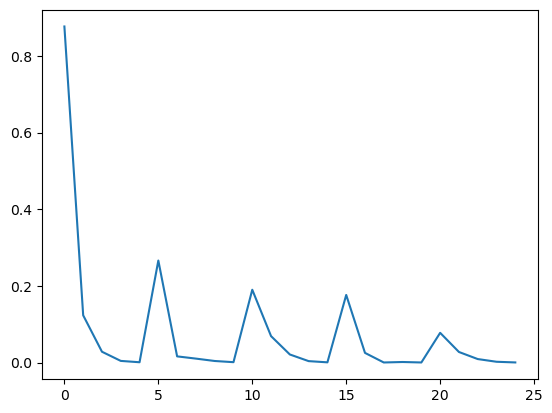

In [193]:
E_0m_norm = E_0m/np.sqrt(np.sum(np.abs(E_0m*np.conjugate(E_0m))))

decompositions = np.zeros(M*N)
for i in np.arange(M*N):
    decomposition = np.abs(np.sum(E_0m_norm*np.conjugate(LG_modes[i])))
    decompositions[i] = decomposition

plt.plot(decompositions)   
plt.show()

### Testing canonical decomposition

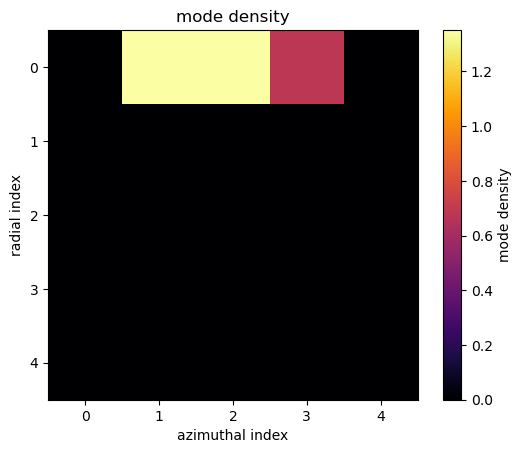

In [337]:
LG_mode1 = LG_mode_gen(0, 1, r, phi, w0)
LG_mode1_norm = LG_mode1/np.sqrt(np.sum(np.abs(LG_mode1)*np.conjugate(LG_mode1)))
LG_mode2 = LG_mode_gen(0, 3, r, phi, w0)
LG_mode2_norm = LG_mode2/np.sqrt(np.sum(np.abs(LG_mode2)*np.conjugate(LG_mode2)))
LG_mode3 = LG_mode_gen(3, 0, r, phi, w0)
LG_mode3_norm = LG_mode3/np.sqrt(np.sum(np.abs(LG_mode3)*np.conjugate(LG_mode3)))

#E_norm = E_0m

LG_mode_sum = (0.5*LG_mode_gen(0, 3, r, phi, w0) + LG_mode_gen(0, 1, r, phi, w0) + LG_mode_gen(2, 0, r, phi, w0) + LG_mode_gen(1, 0, r, phi, w0))
LG_mode_sum = (1*LG_mode_gen(0, 2, r, phi, w0) + 0.5*LG_mode_gen(0, 3, r, phi, w0) + 1*LG_mode_gen(0, 1, r, phi, w0) + 0*LG_mode_gen(2, 0, r, phi, w0))
#E = LG_mode_sum
#E = LG_mode1_norm
#E_norm = E/np.sqrt(np.sum(np.abs(E)*np.conjugate(E)))

# LG_mode_sum = LG_mode1_norm
E = LG_mode_sum

E_norm = E/np.sqrt(np.sum(np.abs(E)*np.conjugate(E)))
E_norm = E/np.sqrt(np.abs(np.sum(np.abs(E)*np.conjugate(E))))

w0 = sigma_x_rms_m  # Beam waist

M = 5
N = 5
LG_modes = ()
indices = ()
decompositions = np.zeros((M,N))
for i in np.arange(M):
    for j in np.arange(N):
        indices += ((i,j),)
        LG_mode = LG_mode_gen(i, j, r, phi, w0)
        LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
        decomposition = np.abs(np.sum(E_norm*np.conjugate(LG_mode)))
        decompositions[i,j] = decomposition

plt.imshow(decompositions, cmap='inferno')
plt.colorbar(label='mode density')
plt.xlabel('azimuthal index')
plt.ylabel('radial index')
plt.title('mode density')
plt.show()


In [324]:
np.abs(np.sqrt(np.sum(np.abs(E)*np.conjugate(E))))

371413.2543230637

In [265]:
decompositions

array([[1.93479801e-15, 1.34598722e+00, 1.53804464e-16, 6.72993608e-01,
        1.47457718e-16],
       [1.34598722e+00, 1.11174987e-15, 2.09439194e-16, 4.79006187e-16,
        6.15305108e-17],
       [1.34598722e+00, 1.38625694e-15, 1.23103590e-16, 2.00748851e-16,
        7.16135674e-16],
       [8.15198815e-16, 9.00457462e-16, 2.85028721e-17, 2.91874761e-16,
        1.15295106e-15],
       [1.52771789e-15, 3.35150671e-16, 1.80233965e-16, 3.03756454e-16,
        1.00373914e-15]])

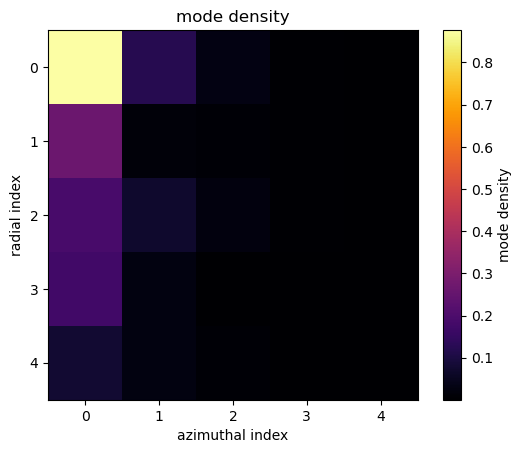

In [208]:
E_0m_norm = E_0m/np.sqrt(np.sum(np.abs(E_0m*np.conjugate(E_0m))))
w0 = sigma_x_rms_m  # Beam waist

LG_modes = ()
indices = ()
decompositions = np.zeros((M,N))
M = 5
N = 5
for i in np.arange(M):
    for j in np.arange(N):
        indices += ((i,j),)
        LG_mode = LG_mode_gen(i, j, r, phi, w0)
        LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
        decomposition = np.abs(np.sum(E_0m_norm*np.conjugate(LG_mode)))
        decompositions[i,j] = decomposition

plt.imshow(decompositions, cmap='inferno')
plt.colorbar(label='mode density')
plt.xlabel('azimuthal index')
plt.ylabel('radial index')
plt.title('mode density')
plt.show()


In [209]:
sigma_x_rms_m

2.3545824972439427e-05

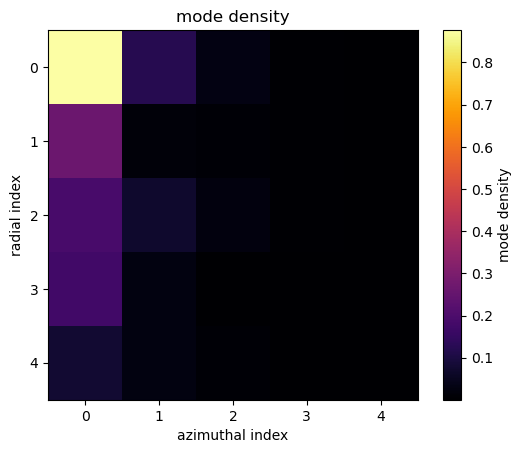

In [213]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
filename = '/Users/awojdyla/Downloads/tender/tender_10m_k=2.0_E=2000ev.mat'

# Load the MATLAB file
data = loadmat(filename)

#unpack data
x_m = np.squeeze(data['x_mm'])*1e-3
y_m = np.squeeze(data['y_mm'])*1e-3
E_eV = data['E_eV']
amplitude = data['amplitude']
phase_rad = data['phase_rad']

# field is sampled at 10m, cast as a complex np array
E_10m = amplitude*np.exp(1j*phase_rad)

# screen size (for propagation)
Dx_m = x_m[-1]-x_m[1]
# equivalent wavelength (used by the propagator)
lambda_m = 1239e-9/E_eV
# distance away from the center of the undulator
z0_m = -10
# backpropagate the beam to the center of the undulator
E_0m = propTF(E_10m,Dx_m,lambda_m, z0_m)

(Itot, mu_x_m, mu_y_m, sigma_x_rms_m, sigma_y_rms_m) = beam_stats_2D(x_m, y_m, np.abs(E_0m)**2)
w0 = sigma_x_rms_m  # Beam waist
w0 = 2.3545824972439427e-05

E_0m_norm = E_0m/np.sqrt(np.sum(np.abs(E_0m*np.conjugate(E_0m))))

LG_modes = ()
indices = ()
decompositions = np.zeros((M,N))
M = 5
N = 5
for i in np.arange(M):
    for j in np.arange(N):
        indices += ((i,j),)
        LG_mode = LG_mode_gen(i, j, r, phi, w0)
        LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
        decomposition = np.abs(np.sum(E_0m_norm*np.conjugate(LG_mode)))
        decompositions[i,j] = decomposition

plt.imshow(decompositions, cmap='inferno')
plt.colorbar(label='mode density')
plt.xlabel('azimuthal index')
plt.ylabel('radial index')
plt.title('mode density')
plt.show()


In [238]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
def undulator_decompose(filename,w0=2.3545824972439427e-05):

    # Load the MATLAB file
    data = loadmat(filename)

    #unpack data
    x_m = np.squeeze(data['x_mm'])*1e-3
    y_m = np.squeeze(data['y_mm'])*1e-3
    E_eV = data['E_eV']
    amplitude = data['amplitude']
    phase_rad = data['phase_rad']

    # field is sampled at 10m, cast as a complex np array
    E_10m = amplitude*np.exp(1j*phase_rad)

    # screen size (for propagation)
    Dx_m = x_m[-1]-x_m[1]
    # equivalent wavelength (used by the propagator)
    lambda_m = 1239e-9/E_eV
    # distance away from the center of the undulator
    z0_m = -10
    # backpropagate the beam to the center of the undulator
    E_0m = propTF(E_10m,Dx_m,lambda_m, z0_m)

    (Itot, mu_x_m, mu_y_m, sigma_x_rms_m, sigma_y_rms_m) = beam_stats_2D(x_m, y_m, np.abs(E_0m)**2)
    #w0 = sigma_x_rms_m  # Beam waist

    E_0m_norm = E_0m/np.sqrt(np.sum(np.abs(E_0m*np.conjugate(E_0m))))

    M = 15
    N = 15
    indices = ()
    decompositions = np.zeros((M,N))

    for i in np.arange(M):
        for j in np.arange(N):
            indices += ((i,j),)
            LG_mode = LG_mode_gen(i, j, r, phi, w0)
            LG_mode = LG_mode/np.sqrt(np.sum(np.abs(LG_mode*np.conjugate(LG_mode))))
            decomposition = np.abs(np.sum(E_0m_norm*np.conjugate(LG_mode)))
            decompositions[i,j] = decomposition

    return decompositions





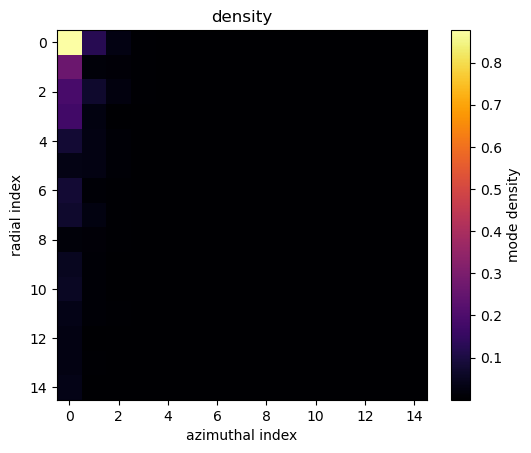

In [248]:
decompositions = undulator_decompose('/Users/awojdyla/Downloads/tender/tender_10m_k=2.0_E=2000ev.mat',w0=23.5e-06)
plt.imshow(decompositions, cmap='inferno')
plt.colorbar(label='mode density')
plt.xlabel('azimuthal index')
plt.ylabel('radial index')
plt.title('density')
plt.show()

In [251]:
decompositions[0,0]

0.8771362806260014